# Checkpoint Three: Cleaning Data

Now you are ready to clean your data. Before starting coding, provide the link to your dataset below.

My dataset:

Import the necessary libraries and create your dataframe(s).

In [1]:
import pandas as pd
import numpy as np

df22 = pd.read_csv(r'C:\Users\chris\PycharmProjects\eda-checkpoint\BACI_HS22_V202501 Data\BACI_HS22_Y2022_V202501.csv', dtype={'k':'str'}) # data for 2022

df23 = pd.read_csv(r'C:\Users\chris\PycharmProjects\eda-checkpoint\BACI_HS22_V202501 Data\BACI_HS22_Y2023_V202501.csv', dtype={'k':'str'}) # data for 2023

country_codes = pd.read_csv(r'C:\Users\chris\PycharmProjects\eda-checkpoint\BACI_HS22_V202501 Data\country_codes_V202501.csv') # country code keys

product_codes = pd.read_csv(r'C:\Users\chris\PycharmProjects\eda-checkpoint\BACI_HS22_V202501 Data\product_codes_HS22_V202501.csv', dtype= str) # product code keys

In [2]:
# Column renames for clarity; joined our two years into one for ease of cleaning.

df = pd.concat([df22, df23])

rename_map = {
    "t": "year",
    "i": "exporter",
    "j": "importer",
    "k": "product",
    "v": "value",
    "q": "quantity"
}

df = df.rename(columns=rename_map)

df.info()

df.head() # Confirmation rename map worked as intended.

<class 'pandas.core.frame.DataFrame'>
Index: 22192308 entries, 0 to 11232738
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   year      int64  
 1   exporter  int64  
 2   importer  int64  
 3   product   object 
 4   value     float64
 5   quantity  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.2+ GB


,year,exporter,importer,product,value,quantity
0,2022,4,20,210610,0.412,0.002
1,2022,4,20,210690,0.070,0.001
2,2022,4,20,271000,6.985,8.103
3,2022,4,20,843131,0.354,0.022
4,2022,4,31,080211,2.250,0.500


## Missing Data

Test your dataset for missing data and handle it as needed. Make notes in the form of code comments as to your thought process.

In [3]:
# Step 1: Used for loops to iterate through our dataframe in order to identify the % of nulls per column - a cleaner way and more informative way to visualize nulls than something like: print(df.isnull().sum())

print(f"CEPI Data:")
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

print('\nProduct Codes:')
for col in product_codes.columns:
    pct_missing = np.mean(product_codes[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

print('\nCountry Codes:')
for col in country_codes.columns:
    pct_missing = np.mean(country_codes[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

# The results showed an immaterial amount of missing data. But I was still paranoid that our important product codes might be unmapped.

# Step 2: Double check explicitly that our product codes are all appropriately mapped.

missing_mask = ~df['product'].isin(product_codes['code']) # creates a boolean mask for unmapped product codes in our dataframe.

missing_rows = df[missing_mask] # brings in rows that are true from our boolean mask.

# missing_rows.head() | no product codes were unmapped.

CEPI Data:
year - 0%
exporter - 0%
importer - 0%
product - 0%
value - 0%
quantity - 4%

Product Codes:
code - 0%
description - 0%

Country Codes:
country_code - 0%
country_name - 0%
country_iso2 - 2%
country_iso3 - 0%


## Irregular Data

Detect outliers in your dataset and handle them as needed. Use code comments to make notes about your thought process.

In [6]:
df.describe() # checking the distribution of the data

df['value'].describe() # check for insane values

df['quantity'].describe() # check for insane values

df['year'].unique() # checking for no irregular years

array([2022, 2023])

## Unnecessary Data

Look for the different types of unnecessary data in your dataset and address it as needed. Make sure to use code comments to illustrate your thought process.

In [5]:
# Unnecessary Data, part 1: Checking for entire-row-level duplicates.

num_duplicate_occurrences = df.duplicated(keep='first').sum()
print("Duplicate rows (excluding first occurrences), CEPI data:", int(num_duplicate_occurrences))

num_duplicate_occurrences = product_codes.duplicated(keep='first').sum()
print("Duplicate rows (excluding first occurrences, product codes):", int(num_duplicate_occurrences))

num_duplicate_occurrences = country_codes.duplicated(keep='first').sum()
print("Duplicate rows (excluding first occurrences, country codes):", int(num_duplicate_occurrences))

Duplicate rows (excluding first occurrences), CEPI data: 0
Duplicate rows (excluding first occurrences, product codes): 0
Duplicate rows (excluding first occurrences, country codes): 0


In [3]:
# Unnecessary Data, part 2:

# Step 1: Replace the country_name for country_code '490' with 'Taiwan' instead of 'Asia, elsewhere not specified' as specified by the dataset creators.

country_codes.loc[country_codes['country_code'] == '490', 'country_name'] = 'Taiwan'

# Step 2: Create a mapping dictionary now that Taiwan's name is consistent.

code_to_name = country_codes.set_index('country_code')['country_name'].to_dict()

# Step 3: Use our new mapping dictionary to add country names to our dataframe.

df['exporter_name'] = df['exporter'].map(code_to_name).fillna(df['exporter'])
df['importer_name'] = df['importer'].map(code_to_name).fillna(df['importer'])

# Step 4: Checking it worked.

df.head()

,year,exporter,importer,product,value,quantity,exporter_name,importer_name
0,2022,4,20,210610,0.412,0.002,Afghanistan,Andorra
1,2022,4,20,210690,0.070,0.001,Afghanistan,Andorra
2,2022,4,20,271000,6.985,8.103,Afghanistan,Andorra
3,2022,4,20,843131,0.354,0.022,Afghanistan,Andorra
4,2022,4,31,080211,2.250,0.500,Afghanistan,Azerbaijan


In [4]:
# Unnecessary Data, part 3:

# Step 1: Adds product description to our dataframe:

df['description'] = df['product'].map(product_codes.set_index('code')['description'])

# Step 2: Created a list of semiconductor codes with descriptions for documentation and to filter out unnecessary data.

semiconductor_codes = [
    "280461", "280469", # high-purity silicon
    "381800", # doped chemical elements | compounds for electronics
    "848610", "848620", "848630", "848640", "848690", # machines & apparatus for semiconductor | wafer manufacture
    "851419", # electric furnaces/ovens for semiconductor manufacture
    "852351", "852352", "852359", # semiconductor media | solid-state storage, smart cards, other
    "854110", "854121", "854129", "854130", "854141", "854143", "854149", "854151", "854159", "854190", # diodes,transistors, photosensitive devices, and parts
    "854231", "854232", "854233", "854239", "854290", # integrated circuits: processors, memories, amplifiers, other ICs and parts
    "903031", "903032", "903033", "903039", "903040", "903082", "903084", "903089", "903090", "903110", "903120", "903141", "903149", "903180", "903190" # measuring, inspection & test equipment used for wafers/devices
    ]

# Filters our dataframe for the products relevant to our analysis using another boolean mask:

mask = df['product'].isin(semiconductor_codes)
df_semis = df[mask]

df_semis.head()

,year,exporter,importer,product,value,quantity,exporter_name,importer_name,description
263,2022,4,40,848640,0.394,0.001,Afghanistan,Austria,Machines and apparatus of a kind used solely o...
266,2022,4,40,852351,1.734,0.020,Afghanistan,Austria,Semiconductor media: solid-state non-volatile ...
446,2022,4,68,903039,7.239,NaN,Afghanistan,Bolivia (Plurinational State of),Instruments and apparatus: for measuring or ch...
511,2022,4,76,903180,1.969,0.007,Afghanistan,Brazil,"Instruments, appliances and machines: for meas..."
853,2022,4,124,854231,0.067,NaN,Afghanistan,Canada,Electronic integrated circuits: processors and...


## Inconsistent Data

Check for inconsistent data and address any that arises. As always, use code comments to illustrate your thought process.

In [6]:
# During my EDA, I discovered that pandas removes trailing zeroes from certain datatypes. So I had pandas read those columns as strings as to avoid removing my precious leading zeroes. Here's the code I used to doublecheck that the trailing zeroes were in place and that my relevant columns contained 6-digits as specified by the readme.

product_codes['code length'] = product_codes['code'].str.len()

unique_pc_lengths = product_codes['code length'].unique()

print(unique_pc_lengths) # this was to confirm that all my product codes were 6 digits long.

df['product length'] = df['product'].str.len()

unique_pc_lengths_df = df['product length'].unique()

print(unique_pc_lengths_df) # confirms all codes are 6-digits long.

[6]
[6]


In [32]:
# df_semis.to_csv('baci_cleaned_for_semiconductor_analysis.csv', index=False)

## Summarize Your Results

Make note of your answers to the following questions.

1. Did you find all four types of dirty data in your dataset? No, 3 out of 4 found. Missing: found and safely ignored; Irregular: not found; Unnecessary: found and cleaned; Inconsistent: found and cleaned.
2. Did the process of cleaning your data give you new insights into your dataset? Yes, it helped me learn the importance of the leading zeroes in the product codes of this dataset. It helped me understand more fully that it is near-spotless and normally distributed (for the type of data it represents).
3. Is there anything you would like to make note of when it comes to manipulating the data and making visualizations? I would benefit from making a column called value-per-tonne and then filtering that column for the top quartile as a proxy for advanced integrated circuits. I would then have a subset of data that would allow my aggregations in Tableau to perform as expected.
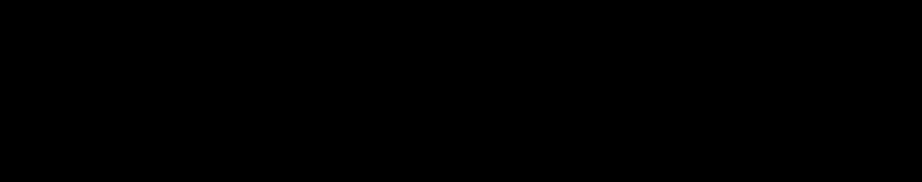
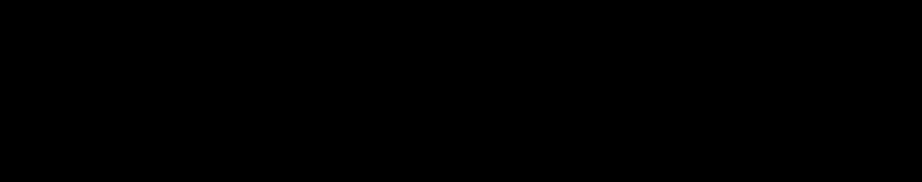
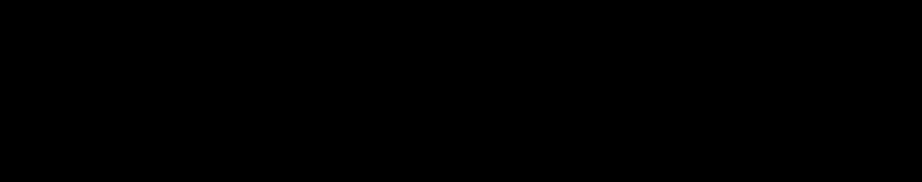